In [2]:
#Downloads what we need for pytorch, the second one is for working with GPU (although I'm not sure if that's 100% correct)

%pip install tensorflow
%pip install tensorflow-datasets
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip -q install tensorflow-datasets pillow torchvision matplotlib
%pip install einops




Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import tensorflow_datasets as tfds #this allows us to get the dataset directly from tensorflow (so CLIC)
#Lowkey the best option might be to install it on our PC/Laptops but like this is technically an option lmao
import numpy as np #numpy lol
from PIL import Image #lets us convert numpy arrays into images
import torch, torch.nn as nn #import numpy

import torch.nn.functional as F #this one is to unfold the patches from their mid token form (for bug testing the encoder basically)

from torchvision import transforms #easy conversion into tensors
import matplotlib.pyplot as plt #matlab lol

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import os, glob


In [5]:
import torch, sys

print("torch version:", torch.__version__)
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.version.cuda:", torch.version.cuda)
print("sys.executable:", sys.executable)

torch version: 2.5.1+cu121
torch.cuda.is_available(): True
torch.version.cuda: 12.1
sys.executable: c:\Users\Yu Xuan Liu\AppData\Local\Programs\Python\Python311\python.exe


In [6]:
class PatchEmbed(nn.Module):
    """
    Conv2D-based patchify:
    - Splits (B, C, H, W) into patches of size patch_size x patch_size. So in our case it would be 32 x 32 to keep it small
    - Projects each patch into an embedding vector of dimension embed_dim

     B: Batch Size
     C: Image Channels
     H: Image Height
     W: Image Width

    """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        # Save attributes for future reference
        self.patch_size = patch_size    # Patch size
        self.embed_dim = embed_dim      # Dimensionality of Model
        self.img_size = img_size        # Image Size
        self.in_chans = in_chans        # Number of Channels

        super().__init__()

        # Conv2d layer: kernel_size = stride = patch_size
        # → splits the image into non-overlapping patches
        # → each patch is projected into `embed_dim` features
        # Basically this is taking a square cookie cutter and then moving it across a big square cookie till u got 16 patches of 32 x 32
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # Input x: (B, C, H, W)
        print(x.shape)
        x = self.proj(x)                        # after conv: (B, embed_dim, grid_h, grid_w)
        x = x.flatten(2).transpose(1, 2)        # flatten spatial grid, then swap → (B, N, D)
                                               # B = batch, N = num_patches, D = embed_dim
        return x
    
    def unpatchify(patches, embed_layer, in_chans):
        """
        Unpatchify it so i can make sure this actually works
        """
        B, N, D = patches.shape                 # (batch, num_patches, embed_dim)
        gh, gw = embed_layer.grid_h, embed_layer.grid_w  # retrieve patch grid dimensions
        return gh, gw                           # just return patch layout info (for visualization checks)

In [7]:
class PositionalEncoding(nn.Module):
    """
    ViTs have no inherent understanding of spatial structure, hence
    we add positional encodings to each patch so that the ViT model can understand
    where each patch is located in respect to the original image.

    We will be making the positional encodings learnable, as this is a better fit for
    the task of image compression.
    
    NOTE: If we find that our results are iffy, we can switch to static embedding as it
    might work better depending on how much data we have (if we don't have much, static
    positional encoding might help with generalization).

    """

    def __init__(self, sequence_len, embed_dim):

        # sequence_len = number of patches
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_len, embed_dim))  # Learnable pos. encodings

    def forward(self, x):

        # Add positional encoding to embeddings
        # x: (B, N, embed_dim) — N should match sequence_len
        x = x + self.positional_encoding

        return x

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, D)
        out, _ = self.attn(x, x, x)
        return out

In [9]:
class ViTEncoderBlock(nn.Module):
    """ 
    The features of each patch are tranformed through a Multi-Layer Perceptron (MLP)
    in this class, after each patch attends to the others, and is normalized for
    stabilization and better gradient flow.

    Essentially, passing through this encoder block encodes local, global, and 
    contextual information (from the other patches) into each patch vector...

    """

    def __init__(self, embed_dim, num_heads, r_mlp=4):
        super().__init__()

        # Normalizing the input BEFORE MHA to improve gradient flow
        # This will stabilize each input in the batch independently,
        # across its features.
        self.ln1 = nn.LayerNorm(embed_dim)  

        # Calling the MHA method we built which will output a model
        # of the relationships between the patches
        self.mha = MultiHeadAttention(embed_dim, num_heads)

        # Normalizes the layer again after attention but before the FFN
        self.ln2 = nn.LayerNorm(embed_dim)

        # A simple Feed-Forward Neural Network... a Multi-Layer Perceptron (MLP)
        # to add non-linearity to the features, as well as transform them: 
        # which will help each patch's representation become more learnable...

        # This MLP contains two hidden layers, with a GELU activation in between.
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * r_mlp),
            nn.GELU(),
            nn.Linear(embed_dim * r_mlp, embed_dim)
        )

    def forward(self, x):

        # Performs the steps outlined in the constructor...
        # 1) Performs MHA with the input layer normalized, and add that to the original input
        x = x + self.mha(self.ln1(x))

        # 2) Normalizes the attended layer, passes that through the MLP, and add that back to the embedding
        x = x + self.mlp(self.ln2(x))

        # note that the shape of x remains the same (B,N,D);
        # the input has just been augmented after being transformed, normalized, and attended
        return x

In [10]:
#Load the CLIC Dataset from Tensorflow Datasets, again i wonder if it would be better to download it lol 
ds = tfds.load("clic", split="train", as_supervised=False, shuffle_files=False)


In [ ]:
class ViTCompressor(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

        self.encoder = PatchEmbed(img_size, patch_size, n_channels, d_model)
        self.pos_encoder = PositionalEncoding(self.n_patches, d_model)

        self.transformer = nn.Sequential(*[
            ViTEncoderBlock(d_model, n_heads) for _ in range(n_layers)
        ])

        # Decoder to reconstruct original patches
        patch_dim = patch_size[0] * patch_size[1] * n_channels
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, patch_dim)
        )

        self.d_model = d_model
        self.n_channels = n_channels

    def forward(self, x):
        B = x.size(0)
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.decoder(x)  # (B, N_patches, patch_dim)

        x = x.transpose(1, 2).contiguous().view(
            B, self.n_channels,
            self.img_size[0] // self.patch_size[0], self.patch_size[0],
            self.img_size[1] // self.patch_size[1], self.patch_size[1]
        )

        # Rearranging patches to image
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
        x = x.view(B, self.n_channels, self.img_size[0], self.img_size[1])
        x = torch.sigmoid(x)
        return x
    

example = next(iter(ds))
img = example["image"]  # shape: (H, W, 3), dtype=tf.uint8

# --- 2. Convert to PyTorch tensor ---
img = np.array(img) / 255.0  # normalize to [0, 1]
img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)

# --- 3. Create model instance ---
d_model = 256
img_size = (img.shape[2], img.shape[3])  # (H, W)
patch_size = (32, 32)

#Crop image
H, W = img.shape[2], img.shape[3]
H = H - (H % patch_size[0])
W = W - (W % patch_size[1])
img = img[:, :, :H, :W]
img_size = (H, W)

n_channels = 3
n_heads = 8
n_layers = 6

model = ViTCompressor(d_model, img_size, patch_size, n_channels, n_heads, n_layers)

# --- 4. Run forward pass ---
with torch.no_grad():
    output = model(img)

torch.Size([1, 3, 832, 1472])


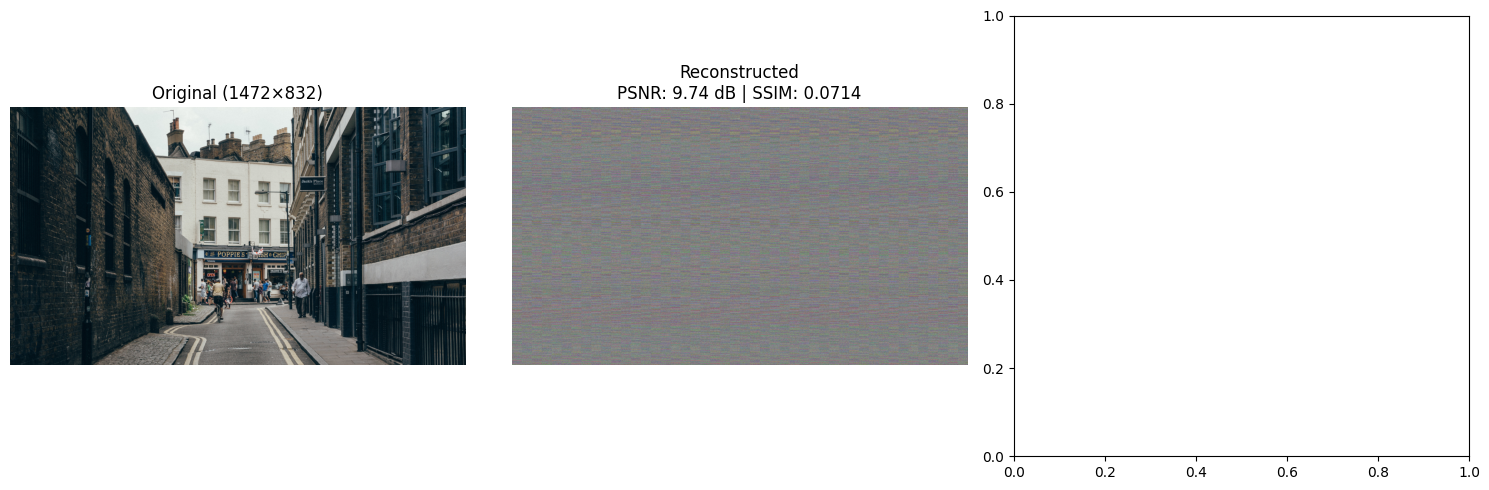

In [13]:
def to_numpy_img(t: torch.Tensor):
    """[1,3,H,W] or [3,H,W] float tensor in [0,1] → HxWx3 numpy"""
    if t.dim() == 4: t = t.squeeze(0)
    t = t.detach().cpu().clamp(0, 1)
    return t.permute(1, 2, 0).numpy()

# get numpy images
img_np   = to_numpy_img(img)           # original
out_np   = to_numpy_img(output)        # reconstructed

# metrics (assuming floats in [0,1])
psnr_val = psnr(img_np, out_np, data_range=1.0)
ssim_val = ssim(img_np, out_np, channel_axis=2, data_range=1.0)

# # error maps, uncomment if u wanna see it
# abs_err  = np.abs(img_np - out_np)                 # per-pixel absolute error
# err_vis  = np.clip(abs_err , 0, 1)           # amplify 10x so you can see artifacts

# show side-by-side + error
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_np)
axs[0].set_title(f"Original ({img_np.shape[1]}×{img_np.shape[0]})")
axs[0].axis("off")

axs[1].imshow(out_np)
axs[1].set_title(f"Reconstructed\nPSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f}")
axs[1].axis("off")

#uncomment if you wanna see Abs error
# axs[2].imshow(err_vis)
# axs[2].set_title("Abs error (clipped)")
# axs[2].axis("off")

plt.tight_layout()
plt.show()

In [26]:
# SANITY CHECK 2: Can the model memorize ONE image?

# check if GPU device is available, if it says cuda then that means vscode can detect ur gpu, if not ur still running using ur cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2) --- PyTorch Dataset wrapper ---
class CLICDataset(Dataset):
    def __init__(self, split="validation"):
        self.ds = tfds.load("clic", split=split, as_supervised=False)
        self.samples = list(self.ds)

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        example = self.samples[idx]
        img = np.array(example["image"]) / 255.0  # convert to float [0,1]
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)

        # resize tensor directly (instead of using T.Resize which expects PIL)
        img = F.interpolate(img.unsqueeze(0), size=(832, 1472), mode='bilinear', align_corners=False).squeeze(0)

        return img  # only return image, no label

# 3) convert ur model to using gpu
model = model.to(device)

# 4) Load exactly one image from your dataset, and move it to GPU
one_loader = DataLoader(CLICDataset("train"), batch_size=1, shuffle=True)
single_img = next(iter(one_loader)).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

single_img = single_img.to(device)
model.train()
for step in range(3000):
    output = model(single_img)
    loss = criterion(output, single_img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step == 1000:
        # lower LR after initial fast learning
        for g in optimizer.param_groups:
            g['lr'] = 1e-4

    if step % 200 == 0:
        print(f"Step {step}: loss = {loss.item():.6f}")

Using device: cuda
torch.Size([1, 3, 832, 1472])
Step 0: loss = 0.177233
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472])
torch.Size([1, 3, 832, 1472

torch.Size([1, 3, 832, 1472])


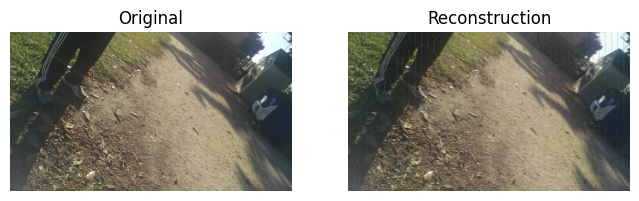

In [ ]:
model.eval()
with torch.no_grad():
    recon = model(single_img)

orig_np  = to_numpy_img(single_img[0])
recon_np = to_numpy_img(recon[0])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig_np);  plt.title("Original");      plt.axis("off")
plt.subplot(1,2,2); plt.imshow(recon_np); plt.title("Reconstruction"); plt.axis("off")
plt.show()

In [ ]:

class KodakDataset(Dataset):
    def __init__(self, root="data_kodak", img_size=(832,1472)):
        self.img_size = img_size

        # Normalize path
        root = os.path.abspath(root)

        # Load PNGs
        self.paths = sorted(glob.glob(os.path.join(root, "*.png")))
        if len(self.paths) == 0:
            raise RuntimeError(f"No PNG images found in: {root}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")

        img = np.array(img) / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2,0,1)

        img = F.interpolate(
            img.unsqueeze(0),
            size=self.img_size,
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return img
    
kodak_loader = DataLoader(
    KodakDataset(root="data_kodak", img_size=(832,1472)),
    batch_size=1,
    shuffle=False
)

In [17]:
kodak_loader = DataLoader(KodakDataset("./data_kodak", img_size=(832,1472)),
                          batch_size=1, shuffle=False)
train_loader = DataLoader(CLICDataset("train"), batch_size=4, shuffle=True)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = ViTCompressor(
    d_model=256,
    img_size=(832,1472),
    patch_size=(32,32),
    n_channels=3,
    n_heads=8,
    n_layers=6
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Optional: adjust LR based on validation (Kodak) loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)

for epoch in range(300):
    # ---- TRAIN ----
    model.train()
    running_train_loss = 0.0
    n_train = 0

    for imgs in train_loader:
        imgs = imgs.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * imgs.size(0)
        n_train += imgs.size(0)

    train_loss = running_train_loss / n_train

    # ---- EVAL ON KODAK ----
    model.eval()
    running_val_loss = 0.0
    n_val = 0

    # for visualization, we'll keep first Kodak image
    first_orig = None
    first_recon = None

    with torch.no_grad():
        for i, imgs in enumerate(kodak_loader):
            imgs = imgs.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, imgs)

            running_val_loss += loss.item() * imgs.size(0)
            n_val += imgs.size(0)

            if i == 0:  # save first image for plotting
                first_orig = imgs.detach().cpu()
                first_recon = outputs.detach().cpu()

    val_loss = running_val_loss / n_val

    # update LR based on Kodak loss
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:3d}: train_loss = {train_loss:.6f} | kodak_loss = {val_loss:.6f}")

    # ---- Visualization on first Kodak image ----
    if first_orig is not None:
        orig_np  = to_numpy_img(first_orig)
        recon_np = to_numpy_img(first_recon)

        psnr_val = psnr(orig_np, recon_np, data_range=1.0)
        ssim_val = ssim(orig_np, recon_np, channel_axis=2, data_range=1.0)
        err_vis  = np.clip(np.abs(orig_np - recon_np) * 10.0, 0, 1)

        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(orig_np)
        axs[0].set_title("Kodak original")
        axs[0].axis("off")

        axs[1].imshow(recon_np)
        axs[1].set_title(f"Reconstructed\nPSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f}")
        axs[1].axis("off")

        axs[2].imshow(err_vis)
        axs[2].set_title("Abs Error ×10")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

Using: cuda


c:\Users\Yu Xuan Liu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size([4, 3, 832, 1472])
torch.Size

KeyboardInterrupt: 

In [ ]:
best_model = ViTCompressor(
    d_model=256,
    img_size=(832,1472),
    patch_size=(32,32),
    n_channels=3,
    n_heads=8,
    n_layers=6
).to(device)

best_model.load_state_dict(torch.load("best_vit_compressor.pth", map_location=device))
best_model.eval()